Use `title` and `question_test` from `stackoverflow` to categorize question topic `tags`. All questions are _statistics_ related.

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import shap
import numpy
import sklearn.metrics as skm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-pack

In [2]:
data = pd.read_csv('./data/stackoverflow_20200916.csv', 
                            index_col=0,header=0, 
                            encoding = "utf8")
data.head(2)

,OwnerUserId,CreationDate,Score,Title,Body,text,r,regression,machine-learning,time-series,...,correlation,statistical-significance,bayesian,anova,normal-distribution,multiple-regression,mixed-model,clustering,neural-networks,mathematical-statistics
Id,,,,,,,,,,,,,,,,,,,,,
6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=...",The Two Cultures: statistics vs. machine learn...,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...,Bayesian and frequentist reasoning in plain En...,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [3]:
data = data.sample(frac=1, random_state=2020)

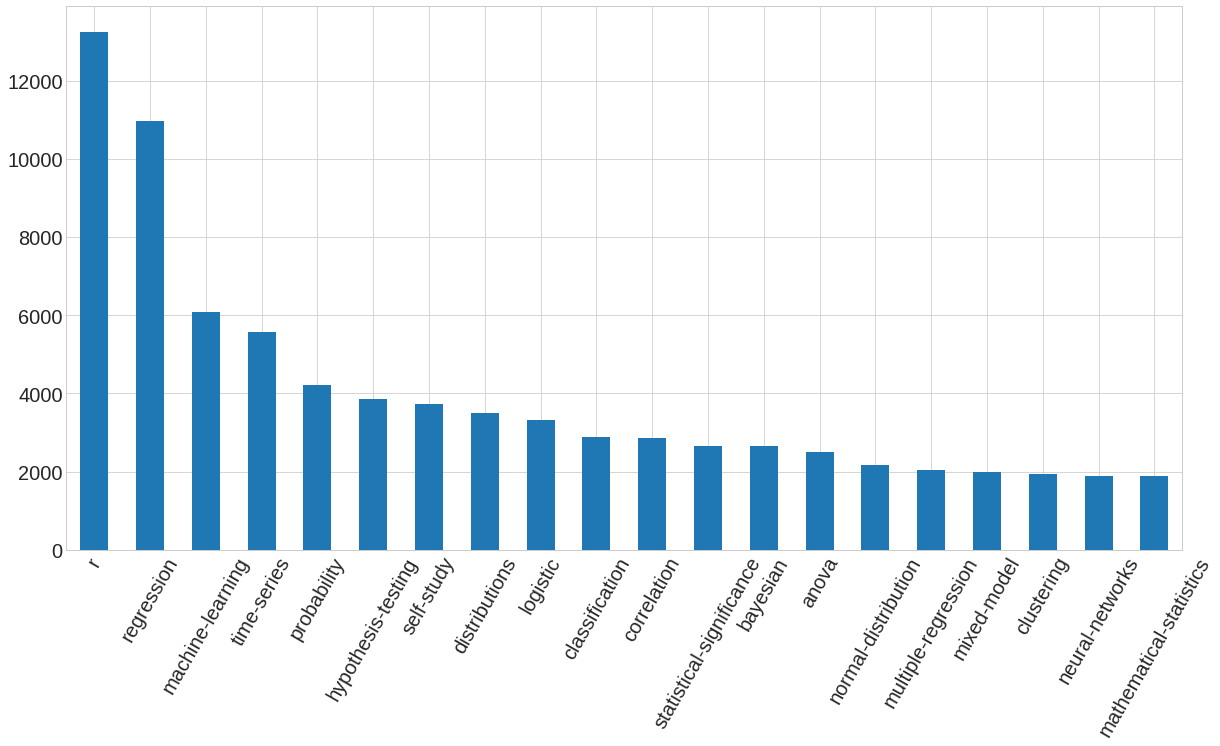

In [4]:
plt.figure(figsize=(20, 10))
SMALL_SIZE=20   
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 
data.iloc[:, 6:].sum(axis = 0, skipna = True).plot(kind='bar');
plt.xticks(rotation=60, fontsize=20);

In [5]:
y_df = data.iloc[:, 6:]

In [6]:
tags = list(y_df.columns)
tags

['r',
 'regression',
 'machine-learning',
 'time-series',
 'probability',
 'hypothesis-testing',
 'self-study',
 'distributions',
 'logistic',
 'classification',
 'correlation',
 'statistical-significance',
 'bayesian',
 'anova',
 'normal-distribution',
 'multiple-regression',
 'mixed-model',
 'clustering',
 'neural-networks',
 'mathematical-statistics']

In [7]:
Y = y_df.values
Y[:5]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

# Load Processed Data

In [8]:
import pickle

file_path = './data/sof-processed-20200917.pickle'
with open(file_path, 'rb') as pickle_file:
    X_train_pad = pickle.load(pickle_file)
    y_train = pickle.load(pickle_file)
    X_test_pad = pickle.load(pickle_file)
    y_test = pickle.load(pickle_file)
    review_text = pickle.load(pickle_file)

In [9]:
VOCAB_SIZE = 20000 #19793
EMBED_DIM = 100
MAX_LENGTH = 200

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_text)

In [11]:
import os
import numpy as np

GLOVE_DIR = '../spam_2019/data/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [12]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i > VOCAB_SIZE:
        continue
    embedding_vector = embeddings_index.get(word, None) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [13]:
embedding_matrix_pos = np.exp(embedding_matrix)

In [14]:
def globe_emb(train_array, emb_dim=100):
    emb_matrix = []
    for x in train_array:
        embs = []
        embs += [embedding_matrix_pos[i] if i < len(embedding_matrix_pos) else np.zeros(emb_dim) for i in x ]
        embs = np.array(embs)
        X_train_emb0 = embs.mean(axis=0)
#         X_train_emb0 = np.sum(embs,axis=0)    
        emb_matrix.append(X_train_emb0)
    emb_matrix = np.array(emb_matrix)
    return emb_matrix

In [15]:
train_matrix = globe_emb(X_train_pad)
test_matrix = globe_emb(X_test_pad)

In [26]:
train_matrix.shape

(45124, 100)

# Modeling

In [19]:
num_tags = y_df.shape[1]

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional,Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 3)

In [31]:
model = Sequential()
#model.add(Input(shape=(100,)))
model.add(Dense(128, activation='relu', input_shape=(100,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_tags, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 20)                660       
Total params: 89,844
Trainable params: 89,844
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(train_matrix, y_train, batch_size = 256 ,  validation_split=0.1, 
                    epochs = 30 , callbacks = [learning_rate_reduction,es])

Train on 40611 samples, validate on 4513 samples
Epoch 1/30
40611/40611 [==============================] - 2s 44us/sample - loss: 0.2745 - acc: 0.9154 - val_loss: 0.2413 - val_acc: 0.9288
Epoch 2/30
40611/40611 [==============================] - 1s 27us/sample - loss: 0.2406 - acc: 0.9291 - val_loss: 0.2411 - val_acc: 0.9288
Epoch 3/30
40611/40611 [==============================] - 1s 27us/sample - loss: 0.2402 - acc: 0.9291 - val_loss: 0.2414 - val_acc: 0.9289
Epoch 4/30
40611/40611 [==============================] - 1s 27us/sample - loss: 0.2398 - acc: 0.9292 - val_loss: 0.2401 - val_acc: 0.9289
Epoch 5/30
40611/40611 [==============================] - 1s 28us/sample - loss: 0.2391 - acc: 0.9293 - val_loss: 0.2396 - val_acc: 0.9292
Epoch 6/30
40611/40611 [==============================] - 1s 27us/sample - loss: 0.2378 - acc: 0.9297 - val_loss: 0.2386 - val_acc: 0.9296
Epoch 7/30
40611/40611 [==============================] - 1s 27us/sample - loss: 0.2369 - acc: 0.9299 - val_loss: 0.2

In [33]:
print('Eval loss/accuracy:{}'.format(model.evaluate(test_matrix, y_test, batch_size = 128)))

11281/11281 [==============================] - 0s 17us/sample - loss: 0.1972 - acc: 0.9354
Eval loss/accuracy:[0.19717509305262626, 0.93544465]


In [34]:
model.save('./models/sof_20200919')

In [35]:
y_test[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [37]:
y_predicted = model.predict(test_matrix, batch_size = 128)
y_predicted[:5]

array([[2.86174893e-01, 2.45302916e-01, 3.52058113e-02, 5.31821251e-02,
        8.41227174e-02, 2.26893127e-02, 1.13235712e-01, 7.60411322e-02,
        4.89986837e-02, 1.42270327e-02, 5.71356118e-02, 2.09546089e-02,
        4.28065956e-02, 2.21006870e-02, 5.91582656e-02, 3.75289023e-02,
        2.25830078e-02, 1.62521005e-03, 1.58998370e-03, 4.72468436e-02],
       [2.65226036e-01, 4.07963723e-01, 9.96506214e-03, 4.75645065e-03,
        1.57663524e-02, 1.62064195e-01, 2.04049349e-02, 1.44995451e-02,
        1.29021376e-01, 1.98098719e-02, 4.05424833e-02, 1.33672148e-01,
        1.69196725e-03, 2.84960955e-01, 6.36267662e-03, 7.42367208e-02,
        1.22275829e-01, 3.44783068e-03, 6.35683537e-05, 5.53074479e-03],
       [5.60431421e-01, 3.68361175e-02, 3.67247164e-02, 7.86187768e-01,
        3.88249159e-02, 3.09477448e-02, 2.20743120e-02, 5.45550585e-02,
        4.34133410e-03, 1.44594014e-02, 6.44524992e-02, 3.75604033e-02,
        3.25995684e-03, 5.01272082e-03, 7.50514865e-03, 6.9254

In [38]:
# preds = y_predicted[:5]
# preds.shape

In [39]:
flat_preds = np.zeros(y_predicted.shape)
# flat_preds[0]
for i in range(y_predicted.shape[0]):
    flat_preds[i] = np.where(y_predicted[i]>=0.5, 1, 0)

flat_preds = flat_preds.astype(int)
flat_preds[:5]
    

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [40]:
assert flat_preds.shape == y_test.shape

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, flat_preds, target_names=tags))

                          precision    recall  f1-score   support

                       r       0.68      0.51      0.58      2684
              regression       0.69      0.23      0.34      2230
        machine-learning       0.43      0.05      0.09      1218
             time-series       0.72      0.47      0.57      1122
             probability       0.75      0.01      0.01       811
      hypothesis-testing       0.00      0.00      0.00       793
              self-study       0.00      0.00      0.00       722
           distributions       0.00      0.00      0.00       686
                logistic       1.00      0.00      0.01       675
          classification       0.00      0.00      0.00       552
             correlation       0.00      0.00      0.00       567
statistical-significance       0.00      0.00      0.00       561
                bayesian       0.00      0.00      0.00       533
                   anova       0.00      0.00      0.00       482
     norm

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


# Interpretation


-TO-DO: random sample the interpretation data **DONE**

In [16]:
from tensorflow import keras

model = keras.models.load_model('./models/sof_20200917-v3')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


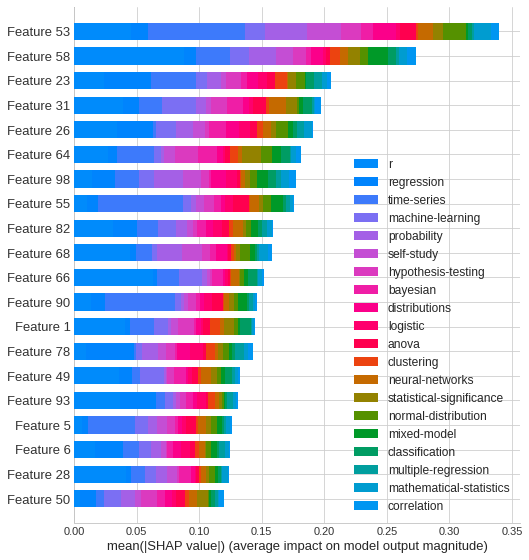

In [43]:
import shap
import numpy as np

attrib_data = train_matrix[:5000]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 500
shap_vals = explainer.shap_values(test_matrix[:num_explanations])

shap.summary_plot(shap_vals, class_names=tags)

In [44]:
file_path = './data/shap_values_20200919.pickle'
with open(file_path, 'wb') as pickle_file:
    pickle.dump(shap_vals, pickle_file)

r


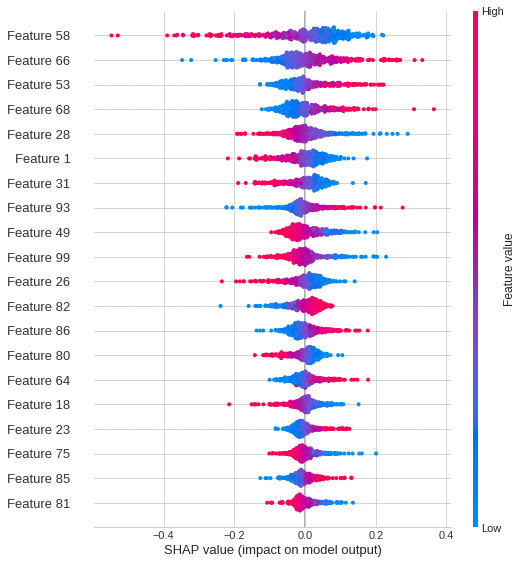

regression


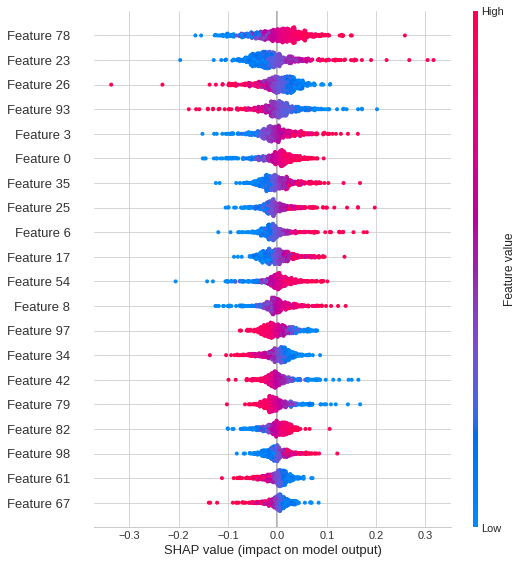

machine-learning


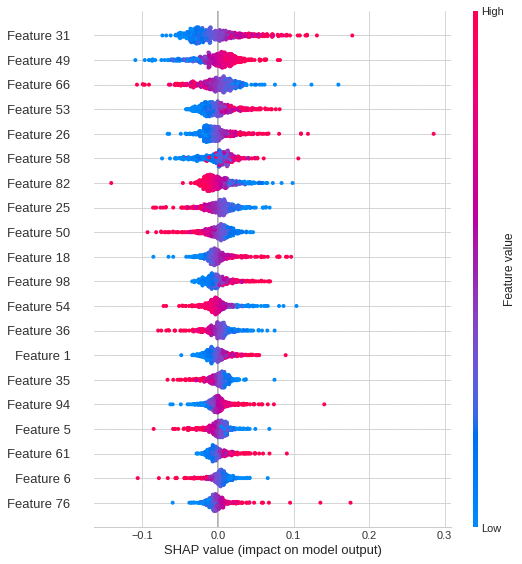

time-series


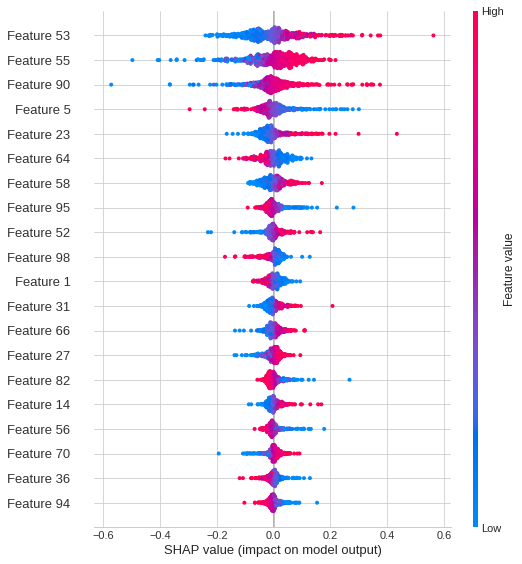

probability


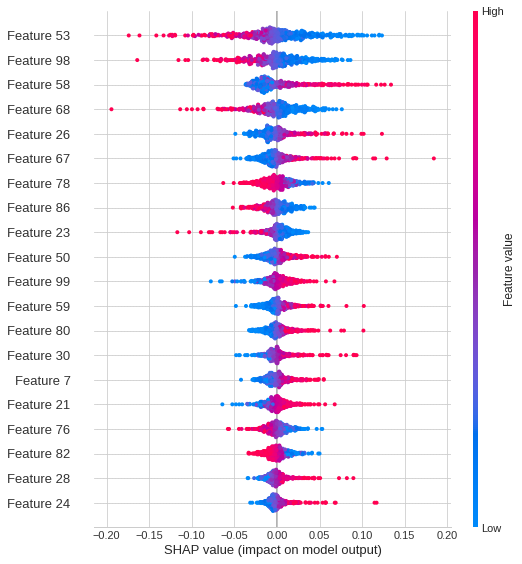

hypothesis-testing


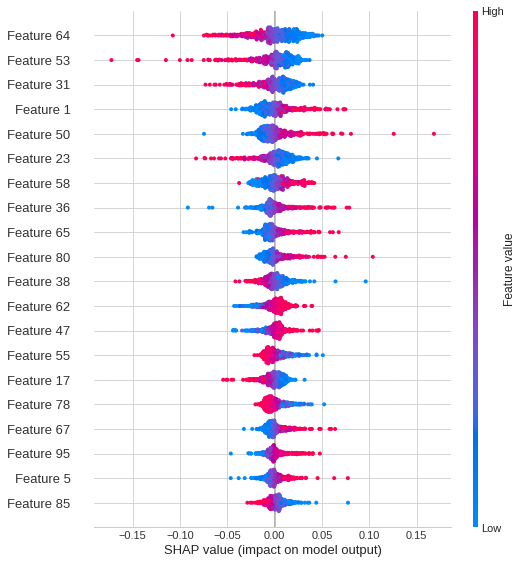

self-study


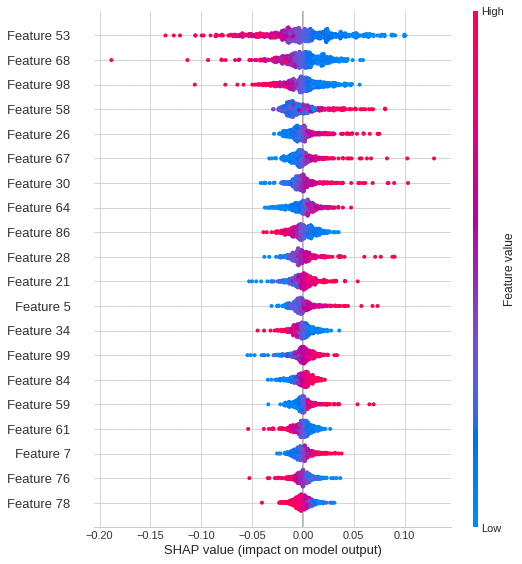

distributions


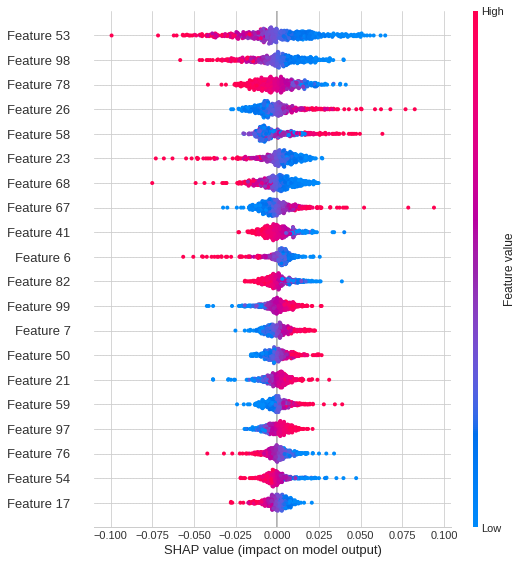

logistic


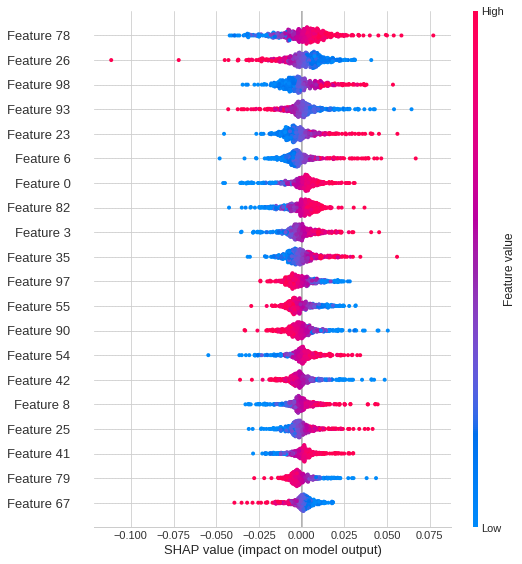

classification


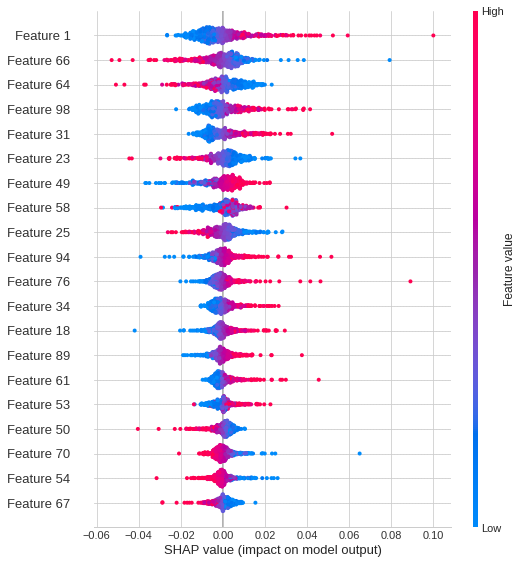

correlation


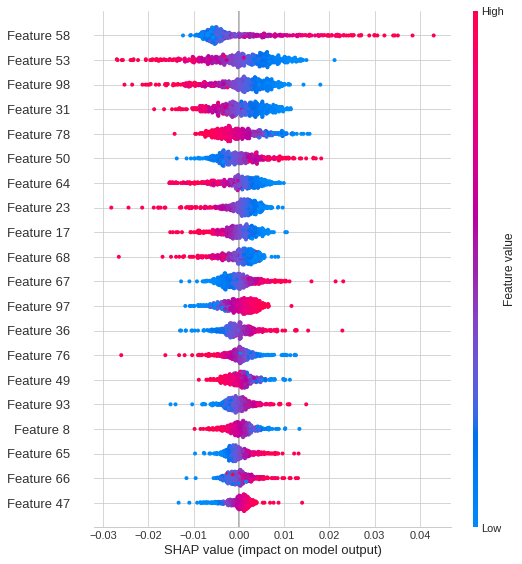

statistical-significance


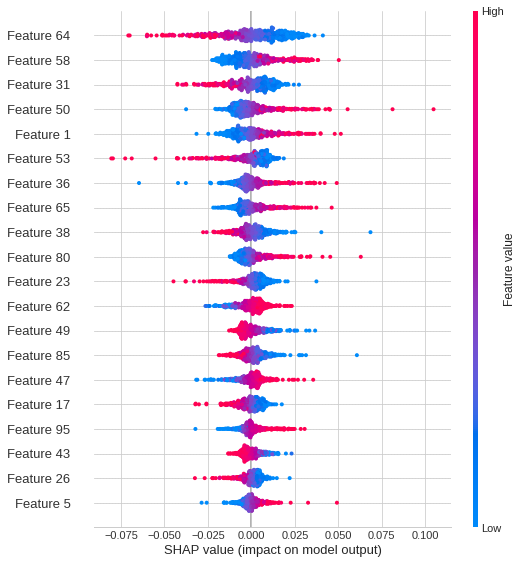

bayesian


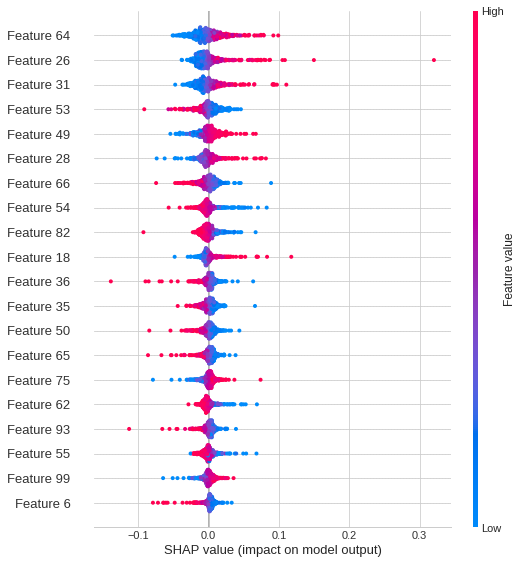

anova


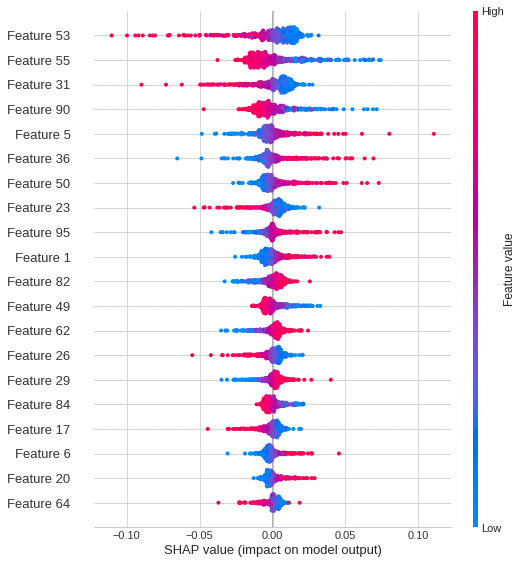

normal-distribution


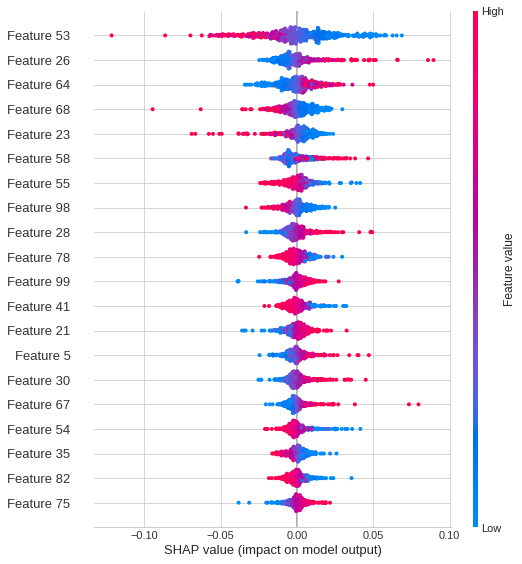

multiple-regression


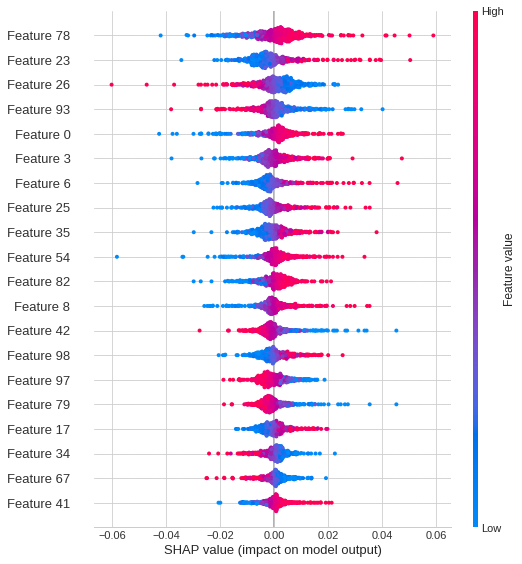

mixed-model


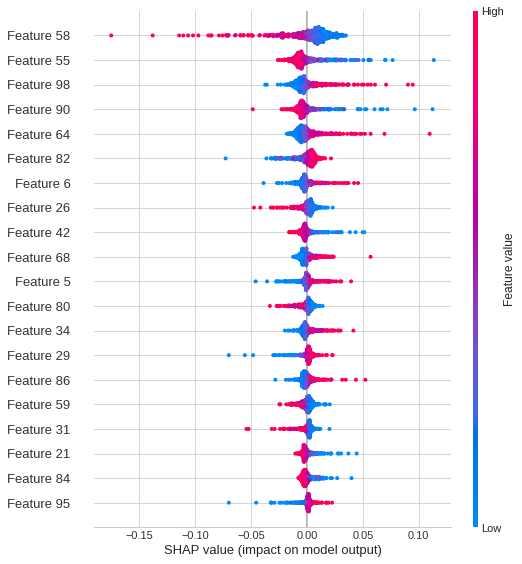

clustering


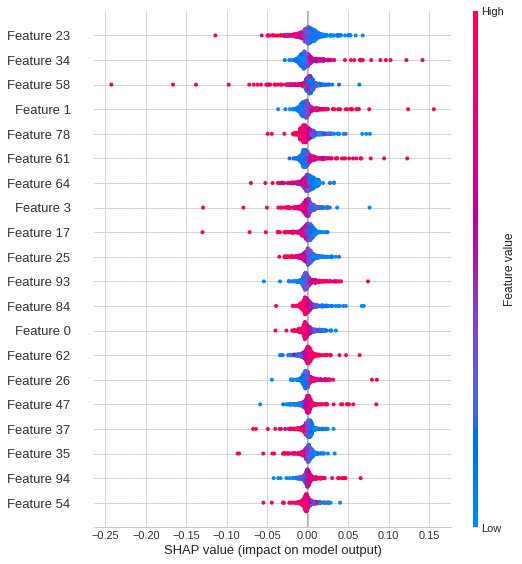

neural-networks


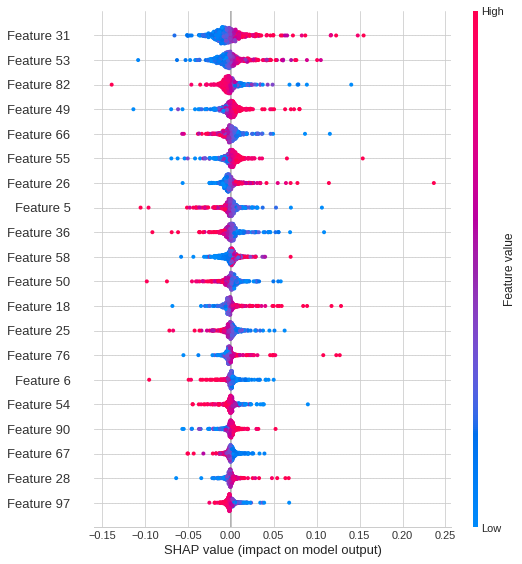

mathematical-statistics


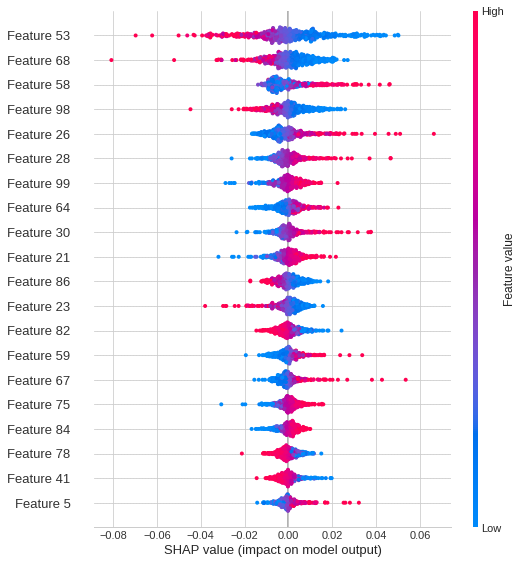

In [45]:
for i in range(20):
    print(y_df.columns[i])
    shap.summary_plot(shap_vals[i], test_matrix[:num_explanations])

In [46]:
shap_vals_arr = np.array(shap_vals)
shap_vals_arr.shape

(20, 500, 100)

In [47]:
shap_vals_global = shap_vals_arr.mean(axis=1)
shap_vals_global.shape

(20, 100)

In [48]:
test_voc = []
for x in X_test_pad[:num_explanations]:
    test_voc.extend(x)
    
test_voc = list(set(test_voc))
len(test_voc)

5505

In [49]:
test_embedding_matrix = []
for t in test_voc:
    if t <= embedding_matrix_pos.shape[1]:
        test_embedding_matrix.append(embedding_matrix_pos[t])
    else:
        test_embedding_matrix.append(np.zeros(100))
test_embedding_matrix = np.array(test_embedding_matrix)
test_embedding_matrix.shape

(5505, 100)

In [50]:
shap_class_word = np.dot(shap_vals_global, test_embedding_matrix.T)
shap_class_word.shape

(20, 5505)

In [51]:
word_lookup = {v:k for k,v in tokenizer.word_index.items()}

In [64]:
for i in range(shap_class_word.shape[0]):
    idx = np.argpartition(shap_class_word[i], -50)[-50:]
    sorted_idx = idx[np.argsort(shap_class_word[i][idx])]
    print(tags[i])
    print('\n')
    print([word_lookup[j] for j in sorted_idx if j != 0])
    print('\n')

r


['q2', 'intend', '35', 'nas', 'today', 'everyon', 'ago', 'consecut', 'l2', 'execut', 'cis', 'guy', 'plug', 'suppli', 'diagram', 'credit', 'vif', 'corpus', 'monoton', 'extern', 'aov', 'bucket', 'rep', 'tip', 'wait', 'perspect', 'aa', 'sold', 'd1', 'np', 'agent', 'primari', 'dec', 'approx', 'environment', 'xlab', 'traffic', 'vec', 'recurr', 'manner', 'thumb', 'argu', 'mice', 'nagq', 'dont', 'seem', 'understand', 'think', 'like', 'know']


regression


['probabl', 'independ', 'featur', 'varianc', 'observ', 'compar', 'mean', 'normal', 'seem', 'follow', 'group', 'run', 'like', 'see', 'predict', 'think', 'c', 'get', 'look', 'need', 'method', 'test', 'want', 'set', 'find', 'work', 'understand', 'tri', 'statist', 'know', 'thank', 'right', 'r', 'b', 'number', 'dont', 'data', 'random', 'plot', 'standard', 'train', 'linear', 'dataset', 'function', 'perform', 'code', 'im', 'level', 'n']


machine-learning


['stress', 'agent', 'aov', 'execut', 'bucket', 'intend', '35', 'nas', 'today', 'everyon